# 线性回归模型从零开始的实现

In [1]:
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

### 生成数据集
设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征 $\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$

In [2]:
num_inputs = 2
num_examples = 1000
features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)

我们使用线性回归模型真实权重 $\boldsymbol{w} = [2, -3.4]^\top$ ，加上偏差 $b = 4.2$和一个随机噪声项 $\epsilon$ 来生成标签
$$
\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon
$$

其中噪声项 $\epsilon$ 服从均值为0、标准差为0.01的正态分布。

In [4]:
true_w = [2, -3.4]
true_b = 4.2
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

`features`的每一行是一个长度为2的向量，`labels`的每一行是一个长度为1的向量

In [6]:
print(features[0], labels[0])

tensor([-2.4230,  0.1528]) tensor(-1.1834)


### 使用图像来展示生成的数据

In [11]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

In [12]:
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

生成第二个特征`features[:, 1]`和标签 `labels` 的散点图

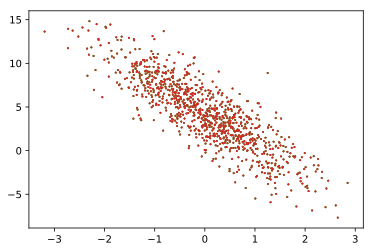

In [15]:
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);
plt.show()

### 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。
定义函数`data_iter`：它每次返回`batch_size`（批量大小）个随机样本的特征和标签。

In [16]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)

In [17]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-0.7507,  0.6598],
        [-0.7170,  0.4516],
        [-2.1960,  0.0136],
        [-1.4269, -0.2806],
        [ 1.6916, -1.0323],
        [ 1.3940, -2.3025],
        [ 0.1410,  0.4889],
        [ 0.5549,  1.7913],
        [ 1.2542,  0.8954],
        [-1.8589,  1.4076]]) tensor([ 0.4597,  1.2263, -0.2203,  2.2947, 11.0728, 14.8227,  2.8135, -0.7751,
         3.6832, -4.3051])


### 初始化模型参数

将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [19]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们要让它们的`requires_grad=True`。

In [20]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

### 定义模型

$$
\hat{y} = x_1 w_1 + x_2 w_2 + b
$$

其中 $w_1$ 和 $w_2$ 是权重（weight），$b$ 是偏差（bias）， $x_1$，$x_2$为输入特征，模型输出 $\hat{y}$ 是线性回归的预测值


使用`mm`函数做矩阵乘法。

In [22]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

### 定义损失函数

使用平方损失来定义线性回归的损失函数。

需要把真实值`y`变形成预测值`y_hat`的形状。函数返回的结果也将和`y_hat`的形状相同。注意：pytorch里的MSELoss并没有除以 2

In [21]:
def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

### 定义优化算法

使用小批量随机梯度下降算法

这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和，将它除以批量大小来得到平均值。

注意：更改param时用的param.data

In [23]:
def sgd(params, lr, batch_size): 
    for param in params:
        param.data -= lr * param.grad / batch_size 

### 训练模型

在训练中，我们将不断迭代模型参数来优化损失函数。


迭代周期个数`num_epochs`和学习率`lr`是超参数

In [26]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

在每次迭代中，我们根据当前读取的小批量数据样本，通过调用反向函数`backward`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。

每个小批量的损失`l`的形状为(10, 1)。所以调用`.sum()`将其求和得到一个标量，再运行`l.backward()`得到该变量有关模型参数的梯度。

注意：每次更新完参数后将参数的梯度清零。

In [27]:
for epoch in range(num_epochs):  
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.037311
epoch 2, loss 0.000136
epoch 3, loss 0.000045


较学到的参数和用来生成训练集的真实参数

In [28]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0002],
        [-3.3996]], requires_grad=True)
4.2 
 tensor([4.2001], requires_grad=True)


# 使用PyTorch的简洁实现

### 生成数据集

在这里生成数据集跟从零开始的实现中是完全一样的。

### 读取数据

PyTorch提供了`data`包来读取数据。由于`data`常用作变量名，我们将导入的`data`模块用`Data`代替。

In [29]:
import torch.utils.data as Data

batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)


## 3.3.3 定义模型

导入`torch.nn`模块。该模块定义了大量神经网络的层。`nn`的核心数据结构是`Module`，它是一个抽象概念，既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络。在实际使用中，最常见的做法是继承`nn.Module`，撰写自己的网络/层。一个`nn.Module`实例应该包含一些层以及返回输出的前向传播（forward）方法。

In [33]:
from torch import nn

class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y
    
net = LinearNet(num_inputs)
print(net) # 使用print可以打印出网络的结构

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


还可以用`nn.Sequential`来更加方便地搭建网络，`Sequential`是一个有序的容器，网络层将按照在传入`Sequential`的顺序依次被添加到计算图中。

In [34]:
# 写法一
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # 此处还可以传入其他层
    )

# 写法二
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


### 初始化模型参数

通过`init.normal_`将权重参数每个元素初始化为随机采样于均值为0、标准差为0.01的正态分布。偏差会初始化为零。

In [35]:
from torch.nn import init

init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, val=0)  # 也可以直接修改bias的data: net[0].bias.data.fill_(0)

Parameter containing:
tensor([0.], requires_grad=True)

### 定义损失函数

PyTorch在`nn`模块中提供了各种损失函数，这些损失函数可看作是一种特殊的层，PyTorch也将这些损失函数实现为`nn.Module`的子类。我们使用它提供的均方误差损失作为模型的损失函数。

In [36]:
loss = nn.MSELoss()


## 3.3.6 定义优化算法

`torch.optim`模块提供了很多常用的优化算法比如SGD、Adam和RMSProp等。下面我们创建一个用于优化`net`所有参数的优化器实例，并指定学习率为0.03的小批量随机梯度下降（SGD）为优化算法。

In [37]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


我们还可以为不同子网络设置不同的学习率

In [39]:
optimizer =optim.SGD([
                # 如果对某个参数不指定学习率，就使用最外层的默认学习率
                {'params': net.parameters(), 'lr': 0.01}
            ], lr=0.03)

### 训练模型

通过调用`optim`实例的`step`函数来迭代模型参数。按照小批量随机梯度下降的定义，我们在`step`函数中指明批量大小，从而对批量中样本梯度求平均。

In [41]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000063
epoch 2, loss: 0.000080
epoch 3, loss: 0.000109


我们从`net`获得需要的层，并访问其权重（`weight`）和偏差（`bias`）

In [42]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 2.0003, -3.4000]], requires_grad=True)
4.2 Parameter containing:
tensor([4.2001], requires_grad=True)
